# Principle Component Analysis (PCA) and Partition Clusters

In this NB, we treat single books as vectors in a space. Markov transitions (e.g. `Subj->Pred`) are treated as individual pairs within the vector. Each book is a column, and each kind of transition is a row. We then use PCA to decompose the multi-dimensional vector into a two dimensional space which can be plotted. 

A second part of this NB is applying a partitioning cluster algorithm, K-Medoids. This method is robust against outliers (cf. Levshina 2015). To determine the ideal number of clusters to request from the algorithm, we create a series of silhouette plots showing the silhouette widths for each proposed cluster.

## Imports & Functions

In [1]:
import collections, os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_samples, silhouette_score
from tf.fabric import Fabric

# put k-medoid clustering function in path
# we can also later experiment with k-means
if __name__ == '__main__' and __package__ is None:
    os.sys.path.append('../../kmedoids')
    os.sys.path.append('../')

import kmedoids
from functions.bhsa import get_data, unique, lbh_books, sbh_books

def make_transitions(feature_dict):
    '''
    Create a matrix with books as columns and transition pairs as rows.
    The function requires a dictionary containing book keys and 
    list values that contain strings of sequential features (at clause level).
    '''
    
    df_Transition_freq = dict() # Transition matrix with frequences
    df_Transition_prob = dict() # Normalized transition matrix

    # a dict to count the transition pairs per book
    transition_pairs = collections.defaultdict(lambda: collections.Counter())
    
    for bookname, clauses in feature_dict.items():
        
        # count transitions using bigrams
        transitions = list()
        for clause in clauses:
            transitions.append("Clause_Begin")
            transitions.extend(clause)
            transitions.append("Clause_End")
            
        for i in range(0, len(transitions)-1):
            
            # assemble transition pair string
            state1 = transitions[i]
            state2 = transitions[i+1]
            transition_string = state1 + '->' + state2
            
            if transition_string == 'Clause_End->Clause_Begin': # ignore clause_begin to end transition pairs
                continue 
            
            transition_pairs[bookname][transition_string] += 1
            
        # create the dataframes
        df_trans = pd.DataFrame(transition_pairs).fillna(0)
        df_prop = df_trans.apply(lambda column: column.values / sum(column.values))
        
    return df_trans, df_prop

def safe_log(number):
    '''
    Evaluate for zero before applying log function.
    '''
    if number == 0:
        return 0
    else:
        return math.log(number)
    
def loglikelihood(k, l, m, n, log):
    '''
    Returns the log-likelihood when the supplied elements are given.
    '''
    
    p1 = (k*log(k)) + (l*log(l)) + (m*log(m)) + (n*log(n))        
    p2 = ((k+l)*log(k+l)) - ((k+m)*log(k+m))
    p3 = ((l+n)*log(l+n)) - ((m+n)*log(m+n))
    p4 = ((k+l+m+n))*log(k+l+m+n)
    llikelihood = 2*(p1-p2-p3+p4)
    return llikelihood

def apply_loglikelihood(comatrix):
    
    '''
    Adjusts values in a cooccurrence matrix using log-likelihood. 
    Requires a cooccurrence matrix.
    '''
    new_matrix = comatrix.copy()
    for target in comatrix.columns:
        for basis in comatrix.index:
            k = comatrix[target][basis]
            
            if not k:
                continue
            
            l = comatrix.loc[basis].sum() - k
            m = comatrix[target].sum() - k
            n = comatrix.values.sum() - (k+l+m)
            ll = loglikelihood(k, l, m, n, safe_log)
            new_matrix[target][basis] = ll

    return new_matrix

def plot_silhouettes(data_vectors, range_n_clusters, scatter=False, randomstate=10):
    
    '''    
    Plot silhouette plots based on a supplied range of K using a supplied method.
    Can also plot an optional scatter plot if PCA transformed vectors are supplied.
    Code modified from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    '''
    
    pairwise_dists = pairwise_distances(data_vectors, metric='cosine')
    
    for n_clusters in range_n_clusters:
        
        # use method to make the clusters
        medoids, clusters = kmedoids.kMedoids(pairwise_dists, n_clusters)
    
        # make cluster labels with index corresponding to target word cluster
        cluster_labels = sorted((i, group) for group in clusters # sort groups by index
                                    for i in clusters[group])
        cluster_labels = np.array(list(group[1] for group in cluster_labels)) # put the groups in indexed order in an array
        
        # Create plots
        if not scatter:
            fig, ax = plt.subplots(1, 1)
            fig.set_size_inches(10, 8)
        else:
            fig, (ax, ax2) = plt.subplots(1,2)
            fig.set_size_inches(18, 7)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(pairwise_dists, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(pairwise_dists, cluster_labels)
                
        # Set x-axis limits
        # The silhouette coefficient can range from -1, 1
        # I set the lower limit a -0.2 since the min with one method is -0.13
        ax.set_xlim([-0.2, 0.06])
        
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(pairwise_dists) + (n_clusters + 1) * 10])
        
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.ocean(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor='black', alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # plot scatter if PCA data is given
        if scatter:
            colors = cm.ocean(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(data_vectors[:, 0], data_vectors[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                        c=colors, edgecolor='k')

            # Labeling the clusters
            centers = data_vectors[medoids]
            # Draw white circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c="white", alpha=1, s=200, edgecolor='k')

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                            s=50, edgecolor='k')

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        

        plt.show()

## Load Biblical Hebrew Data

In [2]:
heb_data = get_data()

print(len(heb_data), 'features ready for analysis...')
print(f'\t{heb_data.keys()}')

4 features ready for analysis...
	dict_keys(['phrase_functions', 'phrase_types', 'word_pos', 'clause_types'])


## Create Vectors

In [3]:
# remove sbh and lbh from phrase_funct data to test books independent of these large groups
for feature in heb_data:
    del heb_data[feature]['lbh']
    del heb_data[feature]['sbh']

print('phrase function books:')
heb_data['phrase_functions'].keys()

phrase function books:


dict_keys(['Genesis', 'Exodus', 'Leviticus', 'Deuteronomy', 'Joshua', 'Judges', '1_Samuel', '2_Samuel', '1_Kings', '2_Kings', 'Esther', 'Ezra', 'Nehemiah', '1_Chronicles', '2_Chronicles'])

### Make & sample the vector matrices

In [4]:
pf_trans_count, pf_trans_prop = make_transitions(heb_data['phrase_functions']) # phrase function matrices
pt_trans_count, pt_trans_prop = make_transitions(heb_data['phrase_types']) # phrase type matrices
pos_trans_count, pos_trans_prop = make_transitions(heb_data['word_pos']) # word pos matrices
ct_trans_count, ct_trans_prop = make_transitions(heb_data['clause_types']) # word pos matrices

features_prop = pf_trans_prop.append(pt_trans_prop).append(pos_trans_prop).append(ct_trans_prop)
# features_prop = .append(pt_trans_prop)
# features_prop.append(pos_trans_prop)
# features_prop.append(ct_trans_prop)


features_prop.head(5) # sample proportion matrix

,1_Chronicles,1_Kings,1_Samuel,2_Chronicles,2_Kings,2_Samuel,Deuteronomy,Esther,Exodus,Ezra,Genesis,Joshua,Judges,Leviticus,Nehemiah
Adju->Adju,0.002988,0.000420,0.000309,0.001633,0.000521,0.000157,0.001039,0.000992,0.001082,0.001870,0.001168,0.000422,0.000520,0.001182,0.001395
Adju->Clause_End,0.025451,0.016173,0.006973,0.025753,0.012590,0.012060,0.016946,0.023471,0.019191,0.024307,0.008969,0.012245,0.008840,0.015362,0.019733
Adju->Cmpl,0.002782,0.001400,0.001172,0.003043,0.001266,0.001175,0.001428,0.002645,0.001310,0.002493,0.000834,0.001267,0.002080,0.002363,0.000997
Adju->Frnt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000312,0.000000,0.000000,0.000000,0.000000,0.000000
Adju->Loca,0.000206,0.000490,0.000000,0.000816,0.000372,0.000157,0.000584,0.000331,0.000626,0.000623,0.000209,0.000633,0.000347,0.000315,0.000000


In [5]:
features_prop.tail(5) # sample proportion matrix

,1_Chronicles,1_Kings,1_Samuel,2_Chronicles,2_Kings,2_Samuel,Deuteronomy,Esther,Exodus,Ezra,Genesis,Joshua,Judges,Leviticus,Nehemiah
xYqX->ZYq0,0.000000,0.000000,0.000000,0.000298,0.000000,0.000312,0.000000,0.000000,0.000229,0.000000,0.000000,0.000425,0.000697,0.000000,0.000000
xYqX->xQt0,0.000393,0.000552,0.000495,0.000596,0.000584,0.001558,0.002825,0.001344,0.000917,0.001199,0.000662,0.001276,0.000000,0.001289,0.001533
xYqX->xQtX,0.000000,0.000828,0.001484,0.000000,0.000292,0.000000,0.000257,0.000000,0.000229,0.000000,0.000166,0.000425,0.000349,0.000000,0.000000
xYqX->xYq0,0.000786,0.000552,0.000742,0.000596,0.000876,0.000312,0.005907,0.000000,0.002979,0.001199,0.000662,0.000000,0.000000,0.001611,0.002299
xYqX->xYqX,0.000000,0.000828,0.000742,0.000298,0.000000,0.001558,0.004622,0.000000,0.000000,0.000000,0.000497,0.000850,0.000349,0.000966,0.000000


In [6]:
features_prop.shape

(1854, 15)

In [7]:
# sanity check for proportions, should equal ~4
features_prop['1_Chronicles'].sum()

3.9999999999999996

In [8]:
# sample test, top values for Chronicles
features_prop['1_Chronicles'].sort_values(ascending=False).head(10)

NmCl->NmCl            0.226897
Clause_Begin->CP      0.158578
Clause_Begin->Conj    0.146007
PP->Clause_End        0.108398
Clause_Begin->conj    0.084357
CP->VP                0.076043
PreC->Clause_End      0.069037
NP->Clause_End        0.068830
subs->Clause_End      0.066268
VP->PP                0.065945
Name: 1_Chronicles, dtype: float64

In [9]:
features_prop['1_Kings'].sort_values(ascending=False).head(10)

Clause_Begin->CP      0.172093
Clause_Begin->Conj    0.146048
PP->Clause_End        0.124624
CP->VP                0.119653
Clause_Begin->conj    0.108055
Conj->Pred            0.092278
VP->PP                0.088077
conj->verb            0.076150
Cmpl->Clause_End      0.071624
subs->Clause_End      0.069598
Name: 1_Kings, dtype: float64

## PCA (2D) and Plot Analyses

In [10]:
pca = PCA(n_components=2)

### Test with Proportions, no adjustments

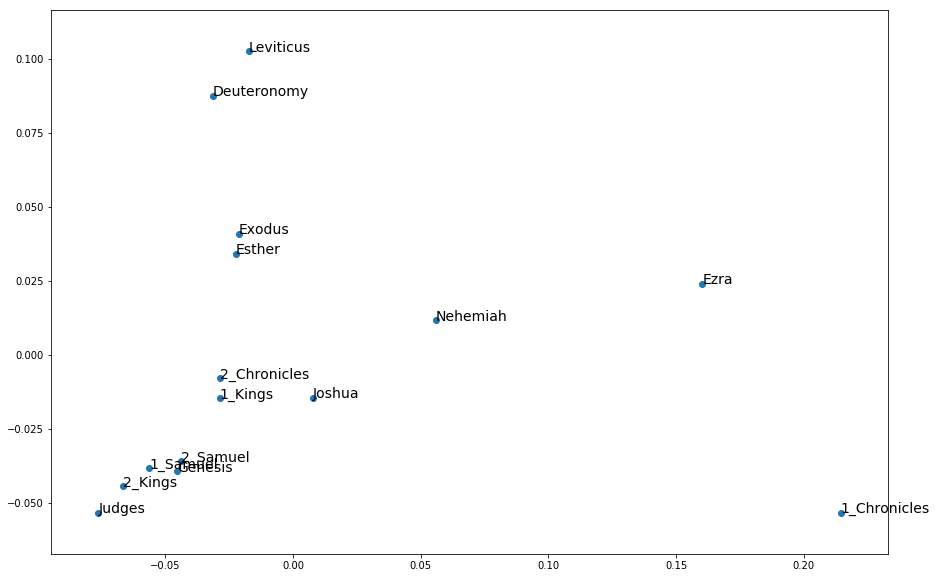

In [11]:
pca_prop = pca.fit_transform(features_prop.T.values) # PCA happens here

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pca_prop[:, 0], pca_prop[:, 1])

# annotate
books = features_prop.columns
for i, book in enumerate(books):
    plt.annotate(book, xy=(pca_prop[i, 0], pca_prop[i, 1]), fontsize=14)

In [12]:
pca_prop = pca.fit_transform(trans_prop.T.values) # PCA happens here

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pca_prop[:, 0], pca_prop[:, 1])

# annotate
books = test_ll.columns
for i, book in enumerate(books):
    plt.annotate(book, xy=(pca_prop[i, 0], pca_prop[i, 1]), fontsize=14)

NameError: name 'trans_prop' is not defined

## PCA (3D) proportions, no adjustments

In [13]:
pca = PCA(n_components=3)

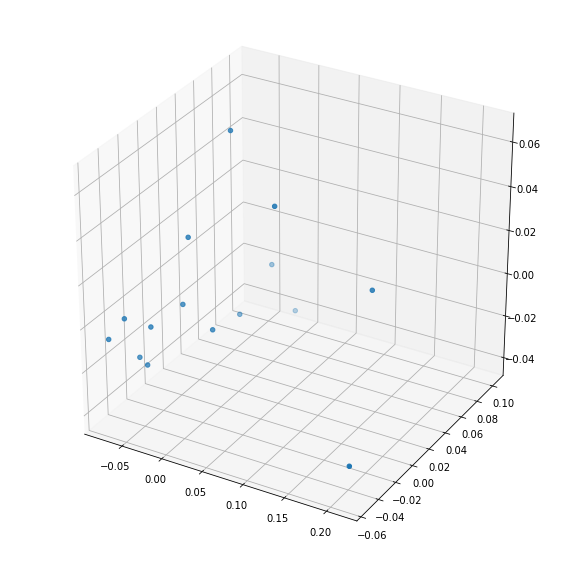

In [14]:
pca_prop = pca.fit_transform(features_prop.T.values) # PCA happens here

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter(pca_prop[:,0], pca_prop[:,1], pca_prop[:,2])

# # annotate
# books = features_prop.columns
# for i, book in enumerate(books):
#     ax.annotate(book, xy=(pca_prop[i, 0], pca_prop[i, 1], pca_prop[i, 2]), fontsize=14)

In [15]:
pca_prop[:,1]

array([-0.0532402 , -0.01455642, -0.03815887, -0.00775563, -0.04440087,
       -0.03596367,  0.08756147,  0.03411859,  0.04098342,  0.0241119 ,
       -0.03921995, -0.01450795, -0.05329917,  0.10254646,  0.01178089])

In [16]:
pca_prop[:,2]

array([-0.03056408,  0.00172409, -0.01745497,  0.03004514,  0.00144202,
       -0.00282361, -0.01477665,  0.06510172, -0.02148684,  0.01505779,
       -0.01943993, -0.00604409, -0.00593804, -0.04087296,  0.04603041])

## Partitioning with K-Medoid

In [34]:
dists = pairwise_distances(pca_prop, metric='cosine')

#plot_silhouettes(pca_prop, list(range(2,11)), randomstate=2, scatter=True)

In [32]:
ll_medoids, ll_clust = kmedoids.kMedoids(dists, 2, state=2)

# show clusters and the books contained in them
for group, ids in ll_clust.items():
    
    print(group)
    
    for i in ids:
        b = features_prop.columns[i]
        print(b, end=' | ')
    print()
    print()

0
1_Chronicles | Deuteronomy | Esther | Exodus | Ezra | Leviticus | Nehemiah | 

1
1_Kings | 1_Samuel | 2_Chronicles | 2_Kings | 2_Samuel | Genesis | Joshua | Judges | 

